# EDA on NYC Fare Prediction Kaggle dataset

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xg

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

In [0]:
import plotly
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from plotly.graph_objs import Scatter, Figure, Layout

Load dataset (30 thousand records for memory constraints)

In [0]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_download = drive.CreateFile({'id':'1JP17D7K7uCaPM63hKvK8MkwQ2nppXyIP'})
train_download.GetContentFile('train.csv')

df_train = pd.read_csv('train.csv',nrows=30000)

In [4]:
print(len(df_train))

30000


In [5]:
#Clean dataset
def clean_df(df):
    return df[(df.fare_amount > 0) & 
            (df.pickup_longitude > -80) & (df.pickup_longitude < -70) &
            (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
            (df.dropoff_longitude > -80) & (df.dropoff_longitude < -70) &
            (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45) &
            (df.passenger_count > 0) & (df.passenger_count < 10)]

df_train = clean_df(df_train)
print(len(df_train))
train_df = df_train
del df_train

29281


In [6]:
train_df.head()

key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [7]:
train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  29281.000000      29281.000000     29281.000000       29281.000000   
mean      11.353151        -73.975058        40.751140         -73.973917   
std        9.603857          0.041539         0.037714           0.039808   
min        0.010000        -75.414728        39.603178         -75.354559   
25%        6.000000        -73.992338        40.736688         -73.991376   
50%        8.500000        -73.982050        40.753567         -73.980584   
75%       12.500000        -73.968270        40.767850         -73.965449   
max      200.000000        -72.856968        43.098708         -72.854940   

       dropoff_latitude  passenger_count  
count      29281.000000     29281.000000  
mean          40.751503         1.673064  
std            0.039837         1.284566  
min           39.604972         1.000000  
25%           40.736067         1.000000  
50%           40.754257         1.000000  
75%           40.768527         2.000000  
max           43.415190         6.000000

<function matplotlib.pyplot.show>

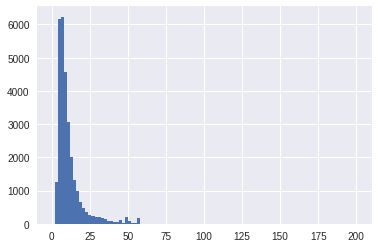

In [8]:
plt.hist(train_df['fare_amount'].values,bins=100)
plt.show

<function matplotlib.pyplot.show>

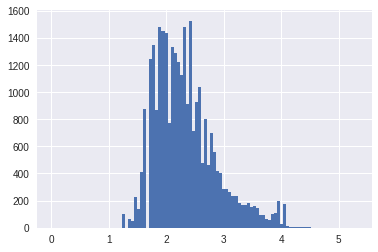

In [9]:
train_df['log_fare_amount'] = np.log(train_df['fare_amount'].values + 1)
plt.hist(train_df['log_fare_amount'].values,bins=100)
plt.show

In [10]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'])
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    
    return dataset

train_df['distance'] = sphere_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude'])

train_df = add_datetime_info(train_df)

train_df.head()

key  fare_amount     pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  log_fare_amount  distance  hour  day  month  weekday  
0                1         1.704748  1.030764    17   15      6        0  
1                1         2.884801  8.450134    16    5      1        1  
2                2         1.902108  1.389525     0   18      8        3  
3                1         2.163323  2.799270     4   21      4        5  
4                1         1.840550  1.999157     7    9      3        1

In [11]:
train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  29281.000000      29281.000000     29281.000000       29281.000000   
mean      11.353151        -73.975058        40.751140         -73.973917   
std        9.603857          0.041539         0.037714           0.039808   
min        0.010000        -75.414728        39.603178         -75.354559   
25%        6.000000        -73.992338        40.736688         -73.991376   
50%        8.500000        -73.982050        40.753567         -73.980584   
75%       12.500000        -73.968270        40.767850         -73.965449   
max      200.000000        -72.856968        43.098708         -72.854940   

       dropoff_latitude  passenger_count  log_fare_amount      distance  \
count      29281.000000     29281.000000     29281.000000  29281.000000   
mean          40.751503         1.673064         2.336047      3.391348   
std            0.039837         1.284566         0.545335      4.343480   
min           39.604972         1.000000         0.009950      0.000000   
25%           40.736067         1.000000         1.945910      1.267537   
50%           40.754257         1.000000         2.251292      2.166670   
75%           40.768527         2.000000         2.602690      3.934749   
max           43.415190         6.000000         5.303305    129.950483   

               hour           day         month       weekday  
count  29281.000000  29281.000000  29281.000000  29281.000000  
mean      13.483453     15.711963      6.263550      3.036440  
std        6.507274      8.682296      3.453829      1.964109  
min        0.000000      1.000000      1.000000      0.000000  
25%        9.000000      8.000000      3.000000      1.000000  
50%       14.000000     16.000000      6.000000      3.000000  
75%       19.000000     23.000000      9.000000      5.000000  
max       23.000000     31.000000     12.000000      6.000000

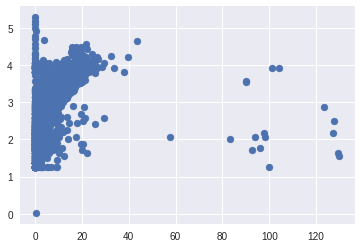

In [12]:
plt.scatter(train_df['distance'],train_df['log_fare_amount'])
plt.show()

Heatmap showing correlations of various features

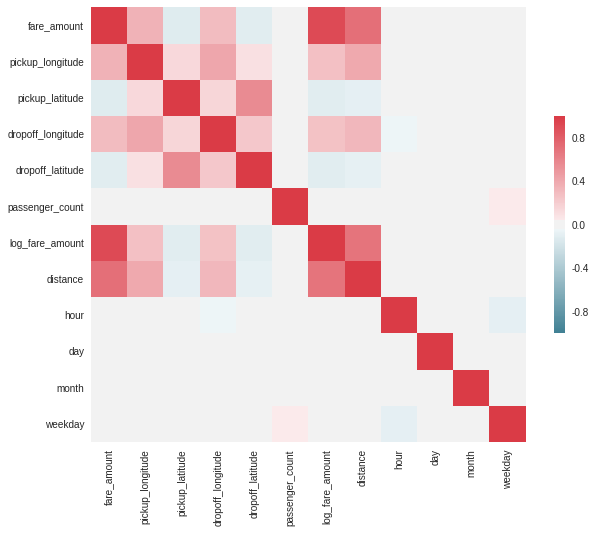

In [13]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = train_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,cbar_kws={"shrink":0.5})

In [14]:
plotly.offline.init_notebook_mode()

Geoplot of the pick up locations in NYC using plotly

In [0]:

data = [go.Scattermapbox(
            lat= train_df['pickup_latitude'] ,
            lon= train_df['pickup_longitude'],
            customdata = train_df['key'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'gold',
                opacity = .8,
            ),
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken="pk.eyJ1IjoicGFyYW5qYXBldmVkIiwiYSI6ImNqa2lra3dzaDE1cW4zcG9haXB5dWIzNjUifQ.qW4vtn3dVCxFg2VwKO5L2Q",
                                bearing=10,
                                pitch=60,
                                zoom=13,
                                center= dict(
                                         lat=40.721319,
                                         lon=-73.987130),
                                style= "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"),
                    width=900,
                    height=600, title = "Pick up Locations in NewYork")

In [0]:
fig = dict(data=data, layout=layout)
iplot(fig)

(The map was not rendered on Google Colab so I uploaded the map from elsewhere)

In [0]:
from google.colab import files
uploaded = files.upload()

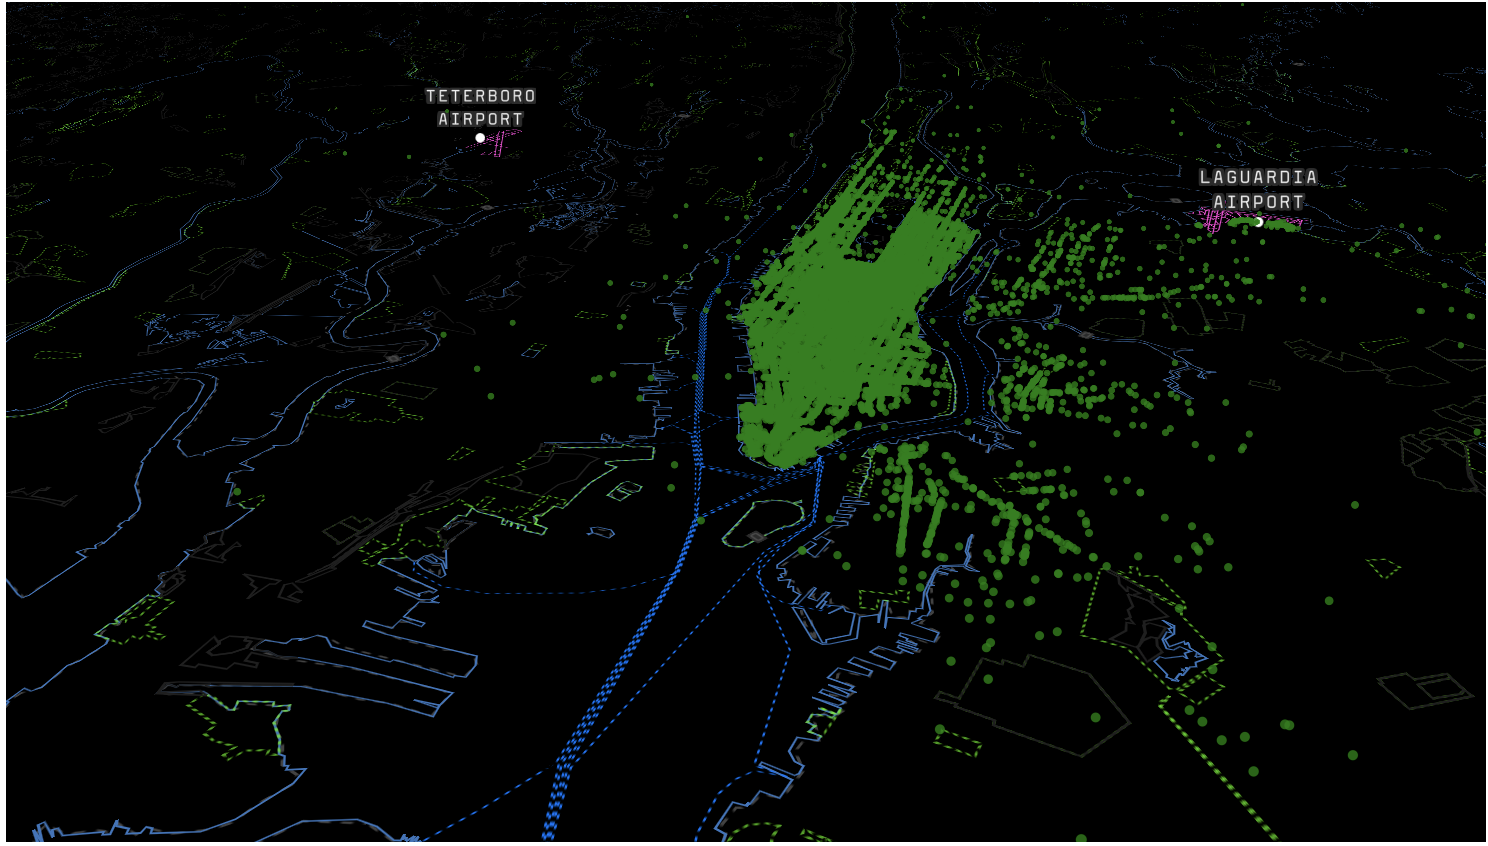

In [20]:
from IPython.display import Image
Image(uploaded['Screen Shot 2018-08-07 at 11.02.19 AM.png'])